In [1]:
import torch
import torchvision
from d2l import torch as d2l
import d2l as d2l_orig
from torch import nn

We use the Reshape class to configure the input dimensions to those expected at the start of the network

In [2]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

Note that we use nn.Flatten() to reduce dimensionality to the 2D input expected by a fully connected layer (where the first dimension is the index of the example in the minibatch)

In [3]:
net = torch.nn.Sequential(
        Reshape(),
        nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),  # 6x28x28
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 6x14x14
        nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),  # 16x10x10
        nn.Sigmoid(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 16x5x5
        nn.Flatten(),  # 1D: 16 * 5 * 5
        nn.Linear(in_features=16*5*5, out_features=120),
        nn.Sigmoid(),
        nn.Linear(in_features=120, out_features=84),
        nn.Sigmoid(),
        nn.Linear(in_features=84, out_features=10))

Check that our shapes are correct:

In [4]:
X = torch.randn(size=(1, 1, 28, 28), dtype=torch.float32)

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "has output shape: \t", X.shape)

Reshape has output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d has output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid has output shape: 	 torch.Size([1, 6, 28, 28])
MaxPool2d has output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d has output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid has output shape: 	 torch.Size([1, 16, 10, 10])
MaxPool2d has output shape: 	 torch.Size([1, 16, 5, 5])
Flatten has output shape: 	 torch.Size([1, 400])
Linear has output shape: 	 torch.Size([1, 120])
Sigmoid has output shape: 	 torch.Size([1, 120])
Linear has output shape: 	 torch.Size([1, 84])
Sigmoid has output shape: 	 torch.Size([1, 84])
Linear has output shape: 	 torch.Size([1, 10])


Let's train it and test it on MNIST. We use torchvision to create the DataLoader for practice

In [5]:
batch_size = 256

In [6]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [17]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

full_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transform, train=False)

train_size = int(0.8 * len(full_set))
val_size = len(full_set) - train_size

train_set, val_set = torch.utils.data.random_split(full_set, [train_size, val_size])

full_iter = torch.utils.data.DataLoader(full_set, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_iter = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

First we define a function to evaluate accuracy on the GPU

In [12]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.size()[0])
    return metric[0] / metric[1]

Now let's search for the best learning rate

In [21]:
lr_options = [0.001, 0.01, 0.1, 0.2]

def param_search_lecun(net, train_iter, val_iter, num_epochs, lr, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights) 
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    best_loss = float("Inf")
    best_epoch = None
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (X, y) in enumerate(train_iter):
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            epoch_loss += l
        # Now get the validation loss
        net.eval()
        val_loss = 0
        for i, (X, y) in enumerate(val_iter):
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            val_loss += loss(y_hat, y)
            
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
        if epoch % 5 == 0:
            print(f'Inside training... epoch number {epoch}, with training loss {epoch_loss:.3f} and validation loss {val_loss:.3f}, using learning rate {lr:.3f}')
    print(f'Lr choice: {lr:.3f} had best loss {best_loss:.3f} at epoch number {best_epoch}')
    return (best_loss, best_epoch)
    
best_loss = float("Inf")
best_epoch = None
best_lr = None
for lr in lr_options:
    loss, epoch = param_search_lecun(net, train_iter, val_iter, 40, lr)
    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch
        best_lr = lr

print(f'Best lr: {lr:.3f}, with loss {best_loss:.3f}, at epoch number {best_epoch}')
    

Inside training... epoch number 0, with training loss 364.239 and validation loss 53.999, using learning rate 0.001
Inside training... epoch number 5, with training loss 106.016 and validation loss 25.953, using learning rate 0.001
Inside training... epoch number 10, with training loss 82.582 and validation loss 21.264, using learning rate 0.001
Inside training... epoch number 15, with training loss 71.190 and validation loss 18.138, using learning rate 0.001
Inside training... epoch number 20, with training loss 64.591 and validation loss 17.357, using learning rate 0.001
Inside training... epoch number 25, with training loss 60.495 and validation loss 16.042, using learning rate 0.001
Inside training... epoch number 30, with training loss 56.899 and validation loss 15.516, using learning rate 0.001
Inside training... epoch number 35, with training loss 54.528 and validation loss 15.152, using learning rate 0.001
Lr choice: 0.001 had best loss 14.662 at epoch number 39
Inside training

KeyboardInterrupt: 

So let's use LR = 0.01.

Now define a training function that:

* moves each minibatch to the GPU to train
* uses Xavier initialisation
* minimise cross-entropy loss, using SGD

In [22]:
def train_lecun(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)

    # Move model to device for training 
    print("Device: ", device)
    net.to(device)
    
#     optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()  # backprop!
            optimizer.step()  # high level API automatically uses backprop
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        
        test_acc = evaluate_accuracy_gpu(net, test_iter, device)
        animator.add(epoch+1, (None, None, test_acc))
    
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.216, train acc 0.920, test acc 0.893
66620.7 examples/sec on cuda:0


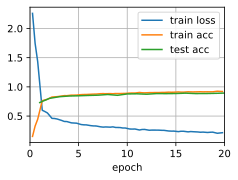

In [23]:
lr = 0.01
num_epochs = 20
train_lecun(net, train_iter, test_iter, num_epochs, lr)

In [31]:
type(train_iter)

torch.utils.data.dataloader.DataLoader